# Access data
- Go to https://appeears.earthdatacloud.nasa.gov/, And get the 16-day, 250m NDVI MODIS product. You can pick either Terra or Aqua satellite, I chose Terra.
- Subregion the area using a `.geojson` file, the contents of which are here:
```json
{
  "type": "FeatureCollection",
  "features": [
    {
      "type": "Feature",
      "properties": {
        "name": "PWWB defined LA Region Bounding Box"
      },
      "geometry": {
        "type": "Polygon",
        "coordinates": [[
          [-118.75, 33.5],
          [-118.75, 34.5],
          [-117.0, 34.5],
          [-117.0, 33.5],
          [-118.75, 33.5]
        ]]
      }
    }
  ]
}
```
- Put in your desired time range, and let it cook

In [1]:
import rasterio
from rasterio.plot import show
import numpy as np
import cv2

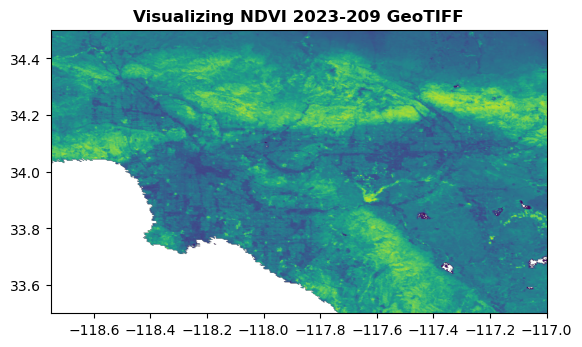

In [2]:
filedir = '/home/mgraca/Workspace/data'
filepath = f'{filedir}/two_years_raw_ndvi_data/MOD13Q1.061__250m_16_days_NDVI_doy2023209000000_aid0001.tif'

# visualize as-is, read as numpy
with rasterio.open(filepath, 'r') as src:
    show(src, title="Visualizing NDVI 2023-209 GeoTIFF")
    ndvi = src.read()

Shape: (1, 481, 841)


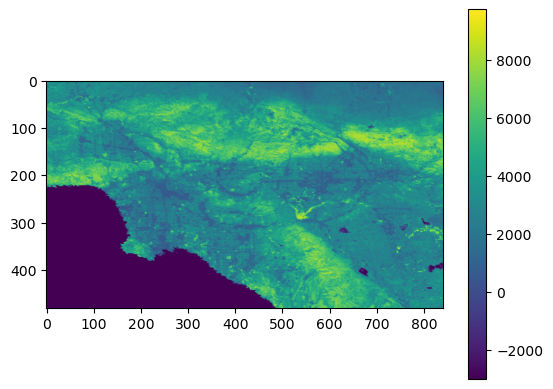

In [3]:
# visualize numpy
import matplotlib.pyplot as plt

print("Shape:", ndvi.shape)
ndvi = np.squeeze(ndvi)

fig, ax = plt.subplots()
im = ax.imshow(ndvi)
plt.colorbar(im, ax=ax)
plt.show()

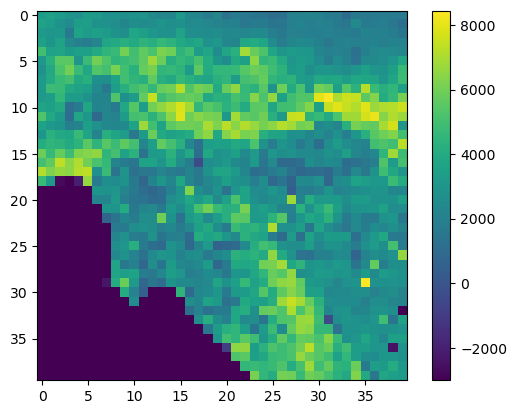

In [4]:
# visualize 40x40
ndvi = cv2.resize(ndvi, (40, 40))
fig, ax = plt.subplots()
im = ax.imshow(ndvi)
plt.colorbar(im, ax=ax)
plt.show()

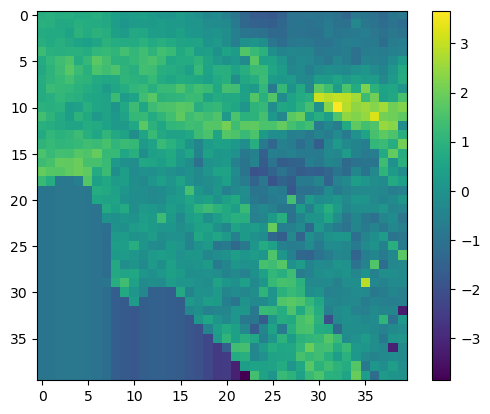

In [5]:
# visualize scaled
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
ndvi = scaler.fit_transform(ndvi)

fig, ax = plt.subplots()
im = ax.imshow(ndvi)
plt.colorbar(im, ax=ax)
plt.show()

# Correlation between elevation, ndvi, and PM2.5

## Elevation

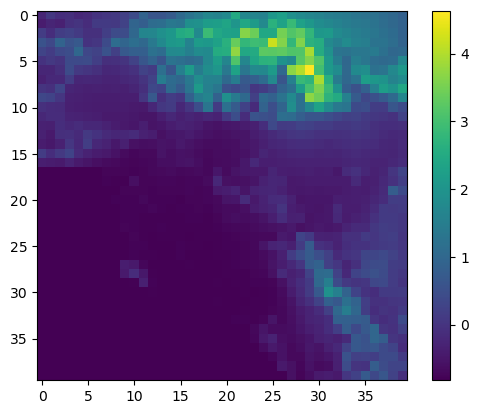

In [6]:
elev = np.load(f'{filedir}/elevation_new.npy')

fig, ax = plt.subplots()
im = ax.imshow(elev)
plt.colorbar(im, ax=ax)
plt.show()

In [7]:
import sys
sys.path.append('/home/mgraca/Workspace/hrrr-smoke-viz')
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
import libs.pwwb.utils.dataset as utils
from libs.airnowdata import AirNowData

START_DATE = "2023-08-02-00"
END_DATE = "2025-08-02-00"
lat_bottom, lat_top = 33.5, 34.5
lon_bottom, lon_top = -118.75, -117.0
extent = (lon_bottom, lon_top, lat_bottom, lat_top)
dim = 40
frames_per_sample = 5

airnow_data = AirNowData(
    start_date=START_DATE,
    end_date=END_DATE,
    extent=extent,
    dim=dim,
    save_dir=None,
    processed_cache_dir='/home/mgraca/Workspace/data/airnow_processed.npz'
)
airnow_data.data.shape

/home/mgraca/miniconda3/envs/tf-hrrrenv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Loading processed AirNow data from cache: /home/mgraca/Workspace/data/airnow_processed.npz
✓ Successfully loaded processed data from cache
  - Data shape: (17544, 40, 40)
  - Found 16 sensor locations


(17544, 40, 40)

In [8]:
X = airnow_data.get_sensor_vals_from_gridded_data(
    np.expand_dims(airnow_data.data, 1),
    airnow_data.air_sens_loc
)
X = X[:, :, :-1] if X.shape[-1] == 16 else X
X = np.squeeze(X)
X.shape

(17544, 15)

In [9]:
# can hijack this airnow function to pull pixels
elev_masked = np.squeeze(
    airnow_data.get_sensor_vals_from_gridded_data(
        np.expand_dims(np.expand_dims(elev, 0), 0), # b/c (s, f, x, y) is expected
        airnow_data.air_sens_loc
    )
)
elev_masked = elev_masked[:-1] if elev_masked.shape[-1] == 16 else elev_masked
elev_masked.shape

(15,)

In [10]:
print(elev_masked)

[-0.05723004 -0.1268812   0.34326416 -0.39774684 -0.75180693 -0.79243678
 -0.80404531 -0.80404531 -0.62217838 -0.51963638 -0.20620614 -0.49254982
  1.03010203  1.30677193  0.28328676]


In [11]:
X_mean = np.mean(X, 0)
X_mean

array([ 7.224467 ,  9.738856 ,  9.641023 , 11.096736 , 12.413076 ,
       11.679668 ,  9.451291 , 10.988238 ,  9.5419235, 12.643286 ,
       12.3059225, 11.374497 ,  7.4813185,  6.682586 ,  7.160611 ],
      dtype=float32)

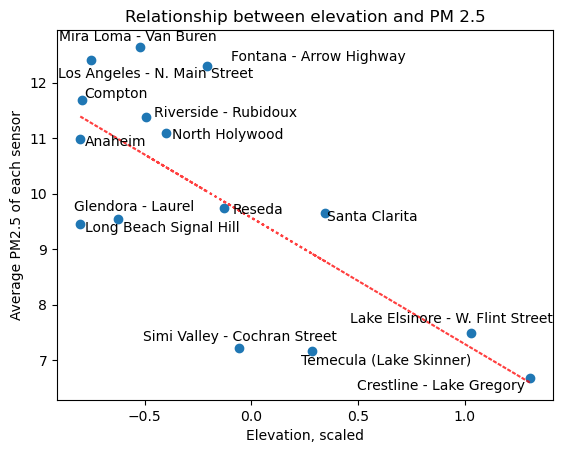

In [12]:
from adjustText import adjust_text

x, y = elev_masked, X_mean
plt.scatter(x, y)
plt.title("Relationship between elevation and PM 2.5")
plt.xlabel("Elevation, scaled")
plt.ylabel("Average PM2.5 of each sensor")

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle=':', alpha=0.75)

labels = list(airnow_data.air_sens_loc)[:-1]
texts = [plt.text(x[i], y[i], txt, ha='center', va='center') for i, txt in enumerate(labels)]

adjust_text(texts, force_static=2)
plt.show()

## NDVI

In [13]:
ndvi_files = []
for file in os.listdir(f'{filedir}/two_years_raw_ndvi_data'):
    with rasterio.open(filepath, 'r') as src:
        raw_ndvi = np.squeeze(src.read())
        resized_ndvi = cv2.resize(raw_ndvi, (40, 40))
        ndvi_files.append(np.expand_dims(resized_ndvi, -1))
ndvi = np.concatenate(ndvi_files, -1)
ndvi.shape

(40, 40, 47)

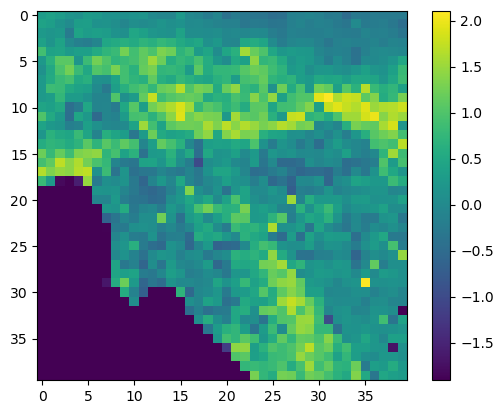

In [14]:
scaler = StandardScaler()
scaled_ndvi = scaler.fit_transform(ndvi.reshape(-1, ndvi.shape[-1])).reshape(ndvi.shape)
mean_ndvi = np.mean(scaled_ndvi, -1)

fig, ax = plt.subplots()
im = ax.imshow(mean_ndvi)
plt.colorbar(im, ax=ax)
plt.show()

In [15]:
# can hijack this airnow function to pull pixels
ndvi_masked = np.squeeze(
    airnow_data.get_sensor_vals_from_gridded_data(
        np.expand_dims(np.expand_dims(mean_ndvi, 0), 0), # b/c (s, f, x, y) is expected
        airnow_data.air_sens_loc
    )
)
ndvi_masked = ndvi_masked[:-1] if ndvi_masked.shape[-1] == 16 else ndvi_masked
ndvi_masked.shape

(15,)

In [16]:
ndvi_masked

array([ 0.84806502, -0.117652  ,  0.35801014, -0.07026131, -0.32336272,
        0.0796337 , -0.05235816, -0.25210116,  0.37661538, -0.09939781,
       -0.00847789,  0.2477829 ,  0.12105667,  1.7460309 , -1.71348973])

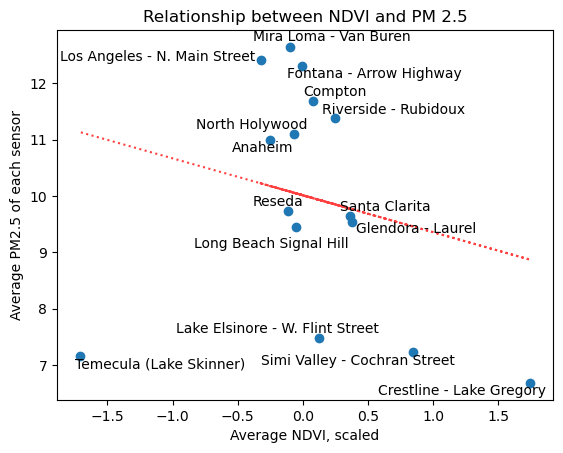

In [17]:
x, y = ndvi_masked, X_mean
plt.scatter(x, y)
plt.title("Relationship between NDVI and PM 2.5")
plt.xlabel("Average NDVI, scaled")
plt.ylabel("Average PM2.5 of each sensor")

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle=':', alpha=0.75)

labels = list(airnow_data.air_sens_loc)[:-1]
texts = [plt.text(x[i], y[i], txt, ha='center', va='center') for i, txt in enumerate(labels)]

adjust_text(texts)
plt.show()

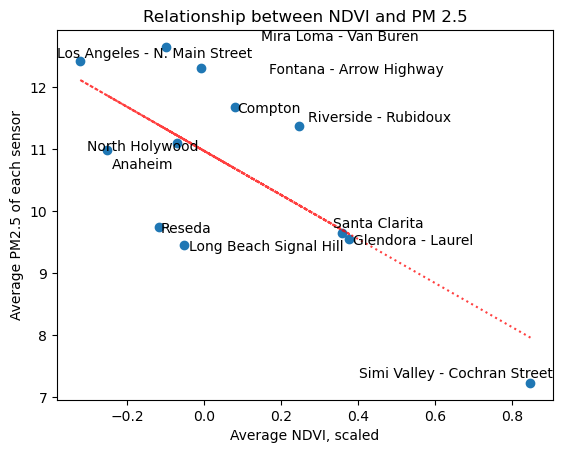

In [21]:
x, y = ndvi_masked[:-3], X_mean[:-3]
plt.scatter(x, y)
plt.title("Relationship between NDVI and PM 2.5")
plt.xlabel("Average NDVI, scaled")
plt.ylabel("Average PM2.5 of each sensor")

m, b = np.polyfit(x, y, 1)
plt.plot(x, m*x + b, color='red', linestyle=':', alpha=0.75)

labels = list(airnow_data.air_sens_loc)[:-4]
texts = [plt.text(x[i], y[i], txt, ha='center', va='center') for i, txt in enumerate(labels)]

adjust_text(texts)
plt.show()